In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

import math

from torch_scatter import scatter
import e3nn
from e3nn import o3
from typing import Dict, Union
from torch_geometric.data import Data
from e3nn.nn.models.gate_points_2101 import smooth_cutoff, tp_path_exists
from e3nn.nn import Gate

from e3nn.o3 import FullyConnectedTensorProduct, TensorProduct
from e3nn.nn import FullyConnectedNet


# crystal structure data
import ase
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

from torch_cluster import radius_graph


from torch.autograd import grad

import torch.nn.utils

from e3nn.o3 import Irrep, Irreps


In [2]:
r_max = 4.0
lmax = 2
num_elements = 3

irreps_edge_attrs_sh = Irreps('1x0e+1x1o+1x2e')
irreps_hidden = Irreps('16x0e + 16x0o +  16x1e + 16x1o +16x2e + 16x2o')

edge_num_basis = 8
invariant_neurons = 8
invariant_layers = 1
num_conv_layer = 2

num_avg_neighbors = 7.0

In [3]:
dftdata = np.load('aspirin_ccsd-train.npz')
xyzdata = ase.io.read('aspirin_ccsd-train.xyz',index=':')

Emean,Estd = dftdata['E'].mean(),dftdata['E'].std()

print(Emean,Estd)

-405685.53076951636 6.524884707789836


In [4]:
# one-hot encoding atom type and mass
#type_encoding = {}
#for Z in tqdm(range(1, num_elements+1), bar_format=bar_format):
#    specie = Atom(Z)
#    type_encoding[specie.symbol] = Z - 1



#print(type_onehot)
type_encoding = {'H':0, 'C':1, 'O':2}
type_onehot = torch.eye(len(type_encoding))

#print(type_encoding)

def build_data(data_index, type_encoding, type_onehot, r_max=4.):
    entry = xyzdata[data_index]
    
    entry_energy = (dftdata['E'][data_index] - Emean)/Estd 
    
 
    site_species = entry.get_chemical_symbols()
    
    
    symbols = list(entry.symbols).copy()
    
    #print(symbols)
    positions = torch.from_numpy(entry.positions.copy()) #.requires_grad_()
    lattice = torch.from_numpy(entry.cell.array.copy()).unsqueeze(0)

    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry, cutoff=r_max, self_interaction=False)
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    edge_len = torch.norm(edge_vec,dim = 1)
    edge_attrs_sh =  o3.spherical_harmonics(irreps_edge_attrs_sh, edge_vec, True, normalization='component')
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        node_attrs=type_onehot[[type_encoding[specie] for specie in symbols]],
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        #edge_src = torch.tensor(edge_src),
        #edge_dst = torch.tensor(edge_dst),
        edge_len = edge_len,
        edge_vec=edge_vec, 
        #edge_attrs_radial = edge_attrs_radial,
        edge_attrs_sh = edge_attrs_sh,
        crystal_energy = torch.tensor(entry_energy)
    )
    
    return data
    
crystal_data = build_data(100, type_encoding, type_onehot, r_max=r_max)
crystal_data


all_data = [build_data(ind, type_encoding, type_onehot, r_max=4.) for ind in range(0,500)]
print(len(all_data))

batch_size = 20
dataloader_train = tg.loader.DataLoader(all_data[:(5*batch_size)],follow_batch=['edge_index'], batch_size=batch_size, shuffle=True)



# all_data[10].node_attrs


500


In [5]:
# from nequip github
def _poly_cutoff(x: torch.Tensor, factor: float, p: float = 6.0) -> torch.Tensor:
    x = x * factor

    out = 1.0
    out = out - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
    out = out + (p * (p + 2.0) * torch.pow(x, p + 1.0))
    out = out - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))

    return out * (x < 1.0)

# from nequip github
class PolynomialCutoff(torch.nn.Module):
    _factor: float
    p: float

    def __init__(self, r_max: float, p: float = 6):
        r"""Polynomial cutoff, as proposed in DimeNet: https://arxiv.org/abs/2003.03123


        Parameters
        ----------
        r_max : float
            Cutoff radius

        p : int
            Power used in envelope function
        """
        super().__init__()
        assert p >= 2.0
        self.p = float(p)
        self._factor = 1.0 / float(r_max)

    def forward(self, x):
        """
        Evaluate cutoff function.

        x: torch.Tensor, input distance
        """
        return _poly_cutoff(x, self._factor, p=self.p)

# from nequip github
class BesselBasis(nn.Module):
    r_max: float
    prefactor: float

    def __init__(self, r_max, num_basis=8, trainable=True):
        r"""Radial Bessel Basis, as proposed in DimeNet: https://arxiv.org/abs/2003.03123
        Parameters
        ----------
        r_max : float
            Cutoff radius
        num_basis : int
            Number of Bessel Basis functions
        trainable : bool
            Train the :math:`n \pi` part or not.
        """
        super(BesselBasis, self).__init__()

        self.trainable = trainable
        self.num_basis = num_basis

        self.r_max = float(r_max)
        self.prefactor = 2.0 / self.r_max

        bessel_weights = (
            torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi
        )
        if self.trainable:
            self.bessel_weights = nn.Parameter(bessel_weights)
        else:
            self.register_buffer("bessel_weights", bessel_weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate Bessel Basis for input x.
        Parameters
        ----------
        x : torch.Tensor
            Input
        """
        numerator = torch.sin(self.bessel_weights * x.unsqueeze(-1) / self.r_max)

        return self.prefactor * (numerator / x.unsqueeze(-1))
    
    
#edge_embed_bessel = BesselBasis(r_max = r_max, num_basis = edge_num_basis, trainable=True)


In [23]:
# from nequip github
def shiftedSoftPlus(x):
    return torch.nn.functional.softplus(x) - math.log(2.0)


# adopted from nequip github (interaction block + convnet layer)
class eqConvLayer(torch.nn.Module):
    def __init__(self, data_irreps) -> None:
        super().__init__()
        
        nonl_scalar = {
            1: shiftedSoftPlus,
            -1: torch.tanh,
        }
        
        nonl_gates = {
            1: shiftedSoftPlus,
            -1: torch.abs,
        }
        
        node_prev_irreps = data_irreps['node_featrues']
        
        irreps_scalars = o3.Irreps(
            [
                (mul, ir) for mul, ir in  data_irreps['node_hidden'] if ir.l==0 and tp_path_exists( node_prev_irreps,data_irreps['edge_sh'],ir)
            ]
        )
        
        irreps_gated = o3.Irreps(
            [
                (mul, ir) for mul, ir in  data_irreps['node_hidden'] if ir.l>0 and tp_path_exists( node_prev_irreps,data_irreps['edge_sh'],ir)
            ]
        )
        
        
        irreps_layer_output = (irreps_scalars+irreps_gated).simplify()
        gate_ir = '0e' if tp_path_exists( node_prev_irreps,data_irreps['edge_sh'],'0e') else '0o'
        irreps_gates = o3.Irreps([(mul,gate_ir) for mul,_ in irreps_gated])
        
        self.eq_nonlinear_layer = e3nn.nn.Gate(
            irreps_scalars = irreps_scalars, 
            act_scalars = [nonl_scalar[ir.p] for _,ir in irreps_scalars], 
            irreps_gates = irreps_gates , 
            act_gates = [ nonl_gates[ir.p] for _,ir in irreps_gates], 
            irreps_gated = irreps_gated
        )
        
        for _,ir in irreps_scalars:
            print('nonlinear scalar',ir,ir.p)
        for _,ir in irreps_gates:
            print('nonlinear gates',ir,ir.p)
        
        # skip resnet for now
        
        
        # convolution part
        irreps_conv_out = self.eq_nonlinear_layer.irreps_in.simplify()
        irreps_conv_in = data_irreps['node_featrues']
        
        self.conv_linear_1 = e3nn.o3.Linear(
            irreps_in = irreps_conv_in,
            irreps_out = irreps_conv_in,
            internal_weights = True,
            shared_weights = True,
        )
        
        irreps_mid = []
        instructions = []
        
        for i,(mul,ir_in) in enumerate(irreps_conv_in):
            for j,(_,edge_ir_in) in enumerate(data_irreps['edge_sh']):
                for ir_out in (ir_in*edge_ir_in):
                    if ir_out in irreps_conv_out:
                        k = len(irreps_mid)
                        irreps_mid.append((mul,ir_out))
                        instructions.append((i,j,k,'uvu',True))
        
        irreps_mid = o3.Irreps(irreps_mid)
        irreps_mid,p,_ = irreps_mid.sort()
        
        instructions = [
            (inp1,inp2,p[out],mode,train)
            for inp1,inp2,out,mode,train in instructions
        ]
        
        self.tp = TensorProduct(
            irreps_conv_in,
            data_irreps['edge_sh'],
            irreps_mid,
            instructions,
            shared_weights = False,
            internal_weights = False,
        )
        
        
        self.fc_weight = FullyConnectedNet([data_irreps['edge_radial'].num_irreps] + invariant_layers*[invariant_neurons] +[self.tp.weight_numel],
                                   act = shiftedSoftPlus)
        
        self.conv_linear_2 = e3nn.o3.Linear(
            irreps_in = irreps_mid.simplify(),
            irreps_out = irreps_conv_out,
            internal_weights = True,
            shared_weights = True,
        )
        
        self.sc=True
        if self.sc:
            self.sc = FullyConnectedTensorProduct(irreps_conv_in,data_irreps['node_attrs'],irreps_conv_out)
        self.output_irreps = irreps_layer_output
        
    def forward(self,data):
        edge_src = data.edge_index[0,:]
        edge_dst = data.edge_index[1,:]
        
        data_z = data.node_features
        
        # convolution
        
        if self.sc:
            data_z_sc = self.sc(data_z,data.node_attrs)
            
            
        data_z = self.conv_linear_1(data_z)
        
        weight = self.fc_weight(data.edge_attrs_radial)
        
        edge_feature = self.tp(data_z[edge_src],data.edge_attrs_sh,weight)
        
        data_z = scatter(edge_feature,edge_dst,dim=0).div(num_avg_neighbors**0.5)
        
        data_z = self.conv_linear_2(data_z)
        
        data_z = self.eq_nonlinear_layer(data_z)
        
        data.node_features = data_z
        
        


class Network(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        data_irreps = {
            'node_attrs': Irreps(str(num_elements)+'x0e'),
            'node_featrues': Irreps(str(num_elements)+'x0e'),
            'edge_radial': Irreps(str(edge_num_basis)+'x0e'),
            'edge_sh': Irreps(irreps_edge_attrs_sh),
            'node_hidden' : Irreps(irreps_hidden),
        }
        
        self.edge_cutoff = PolynomialCutoff(r_max)
        self.edge_embed_bessel = BesselBasis(r_max = r_max, num_basis = edge_num_basis, trainable=True)
        
        for (mul,ir) in data_irreps['node_hidden']:
            if ir.l==0 and ir.p==1:
                atom_embed_irrep = Irreps([(mul,(ir.l,ir.p))])
        
        self.node_embed = o3.Linear(data_irreps['node_featrues'], atom_embed_irrep)
        
        data_irreps['node_featrues'] = atom_embed_irrep
        
        self.conv1 = eqConvLayer(data_irreps)
        
        data_irreps['node_featrues'] = self.conv1.output_irreps
        
        
        self.conv2 = eqConvLayer(data_irreps)
        data_irreps['node_featrues'] = self.conv2.output_irreps
        
        self.conv3 = eqConvLayer(data_irreps)
        data_irreps['node_featrues'] = self.conv3.output_irreps
        
        final_conv_layer = self.conv3
        
        for (mul, ir) in final_conv_layer.output_irreps:
            if ir == Irrep('0e'):
                out_linear_mul = mul // 2

        
        self.out_layer1 = o3.Linear(final_conv_layer.output_irreps,str(out_linear_mul)+'x0e',biases=False)
        
        self.out_layer2 = o3.Linear(str(out_linear_mul)+'x0e','1x0e',biases=False)
        
        
    def forward(self,data):
        data.node_features = self.node_embed(data.node_attrs)
        edge_attrs_rcutoff = self.edge_cutoff(data.edge_len) #.unsqueeze(-1)
        
        
        data.edge_attrs_radial = self.edge_embed_bessel(data.edge_len) * edge_attrs_rcutoff[:,None]
        
        self.conv1(data)
        self.conv2(data)
        self.conv3(data)
        
        atom_data_output = self.out_layer2(self.out_layer1(data.node_features)).squeeze(-1)
        
        atom_data_batch_output = scatter(atom_data_output,data.batch,reduce='sum')
        data.node_features_output = atom_data_batch_output
        
        return data.node_features,atom_data_batch_output

In [24]:
model = Network()
    

nonlinear scalar 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear scalar 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear scalar 0e 1
nonlinear scalar 0o -1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1


In [39]:

model = Network()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_fn = torch.nn.MSELoss()

device = 'cpu'

model.to(device)


max_iter = 700

all_loss = []
all_loss_mean = []

for step in range(max_iter):
    model.train()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    
    for dataset in dataloader_train:
        
        #print('in iteration')
        model_z,model_energy = model(dataset)
        
        loss_energy = loss_fn(model_energy,dataset.crystal_energy).cpu()
        loss = loss_energy 
        
        #print(loss_energy)
        
        loss_cumulative = loss_cumulative + loss.detach().item()
    
        all_loss.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
    print(loss_cumulative/len(dataloader_train))
    all_loss_mean.append(loss_cumulative/len(dataloader_train))


nonlinear scalar 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear scalar 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear scalar 0e 1
nonlinear scalar 0o -1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
nonlinear gates 0e 1
0.9683505936743986
0.9611838631214205
0.9575282982609938
0.9546472883815106
0.9495448010682257
0.9329789212843028
0.9424818841724099
0.9413131053134253
0.933100228530148
0.9265814834525301
0.917511199884957
0.9245163247066124
0.9166555514258825
0.9082338892943408
0.8878932020001684
0.9137577344834055
0.8687503964840044
0.8528500608820453
0.858523011544922
0.8001885261519728
0.780802008537116
0.7697995918647236
0.7108312162221322
0.6670083546347583
0.6138534334766195
0.5857476273169158
0.5045775618827422
0.6170201792880594
0.5920720511106387
0.6214783739840244
0.5278250647412422
0.4898951038678919
0.4377250860340721
0.44161783899051577
0.4673830297951052
0.43058342788036985
0.3915046616544557


0.0006241079755141796
0.0004083094003238372
0.00033685318134574107
0.00036970944936077057
0.00030289209176007943
0.000282049441797261
0.00030294649769413646
0.00020113186696777032
0.00015809424356595154
0.00022440470964975602
0.00017591209228895192
0.00022526575456447944
0.000391589532787225
0.0003837460975292268
0.00020611679645340624
0.00017305574622183454
0.00016204776257146188
0.00011142407109446247
8.241674931656598e-05
8.841646024299198e-05
6.382189274300335e-05
4.467441440249133e-05
4.814255914635761e-05
3.878503186729522e-05
3.850317104412902e-05
3.568325148578004e-05
2.967313014616814e-05
2.1160577730471214e-05
2.0182298210769817e-05
1.2396608176471459e-05
1.8038294336846124e-05
1.2025313360697915e-05
1.408590226237059e-05
1.3057183192768196e-05
1.2900934074662946e-05
1.376213712142374e-05
2.3157841991245385e-05
2.673763358090949e-05
1.841485775102961e-05
2.8786624114594317e-05
2.3570656938433732e-05
1.5756004365129324e-05
2.8908028545338245e-05
2.875674321792789e-05
2.4725723

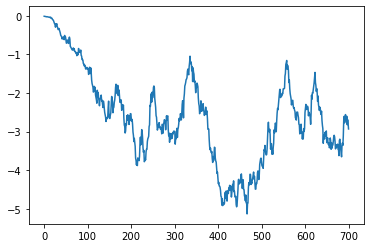

In [45]:
plt.plot(np.log10(all_loss_mean))

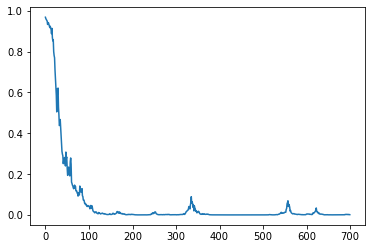

In [46]:
plt.plot((all_loss_mean))